# Intro

In this script we will work on finding a good model nad optimal ammount of clusters for precomputed set of centroid distances for each image. (For more information head to Generate_depth10_allPixels file)

# Libraries and Set

In [2]:
from visualizations import *
import numpy as np
import pandas as pd
import warnings
from math import tau
import matplotlib.pyplot as plt
from scipy.integrate import quad
warnings.filterwarnings('ignore')

In [3]:
data = np.loadtxt("./../DATA/digits2k_pixels.data.gz", ndmin=2)/255.0
data.shape = (data.shape[0], int(np.sqrt(data.shape[1])), int(np.sqrt(data.shape[1])))
labels = np.loadtxt("./../DATA/digits2k_pixels.labels.gz", dtype='int')

In [4]:
centroid_distances = np.load('centroid_distances.npy') # thats our frame of 30-dimensional points to compare with each other via clustering

labels[i] correspond to centroid_distances[i]

# Searching for optimal clusters number in aglomerative

In [5]:
def count_clustering_scores(X, cluster_num, model, score_fun):
    if isinstance(cluster_num, int):
        cluster_num_iter = [cluster_num]
    else:
        cluster_num_iter = cluster_num
        
    scores = []    
    for k in cluster_num_iter:
        model_instance = model(n_clusters=k)
        labels = model_instance.fit_predict(X)
        wcss = score_fun(X, labels)
        scores.append(wcss)
    
    if isinstance(cluster_num, int):
        return scores[0]
    else:
        return scores

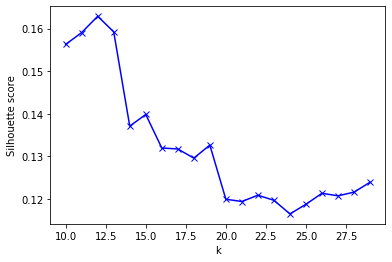

In [6]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering

model_test = AgglomerativeClustering
cluster_num_seq = range(10, 30) # minimum 10 clusters
silhouette_vec = count_clustering_scores(centroid_distances, cluster_num_seq, model_test, silhouette_score)
plt.plot(cluster_num_seq, silhouette_vec, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.show()

### So silhouette score suggests to use 12 clusters, let's check it then

In [7]:
model = AgglomerativeClustering(n_clusters=12, linkage='ward')
model.fit(centroid_distances)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=12,
                        pooling_func='deprecated')

In [8]:
model.labels_

array([ 2,  5, 10, ...,  6,  8,  5], dtype=int64)

### Testing model

In [9]:
np.unique(labels[model.labels_ == 0], return_counts=True)

(array([2, 3, 4, 5, 7, 8, 9]),
 array([  9,   3,   1,   2,  57,   2, 132], dtype=int64))

# Searching for optimal clusters in KMeans

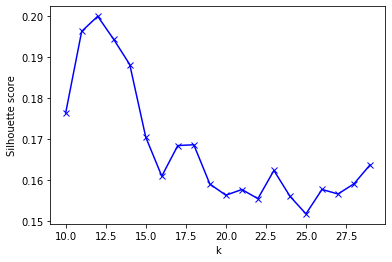

In [10]:
from sklearn.cluster import KMeans

model_test = KMeans
cluster_num_seq = range(10, 30) # minimum 10 clusters
silhouette_vec = count_clustering_scores(centroid_distances, cluster_num_seq, model_test, silhouette_score)
plt.plot(cluster_num_seq, silhouette_vec, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.show()

Better results than agglomerative

### Testing model

In [11]:
model = KMeans(n_clusters=12)
model.fit(centroid_distances)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=12, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [12]:
np.unique(labels[model.labels_ == 3], return_counts=True)

(array([0, 6, 8, 9]), array([156,   2,  11,   3], dtype=int64))

# But is silhoutte score that good for our model?

It would be much better to test our own scorer - how much is a cluster dominated by one number

In [73]:
def dominanceOfPredictedClusters(labels_pred, labels_true):
    clusters = np.unique(labels_pred)
    cluster_dominance = []
    cluster_sizes = []
    N = len(labels_pred)
    for l in clusters:
        labels_in_cluster = np.bincount(labels[np.where(labels_pred==l)])
        cluster_dominance.append(np.max(labels_in_cluster)/np.sum(labels_in_cluster))
        cluster_sizes.append(len(labels[np.where(labels_pred==l)]))
    # mean needs to be counted with wages, to omit situation when all but one clusters are super balanced
    return np.average(cluster_dominance, weights=cluster_sizes)
# the closer it is to one, the more dominated the clusters are, meaning the better is our model

In [74]:
def count_clustering_scores(X, cluster_num, model, score_fun, labels_true):
    if isinstance(cluster_num, int):
        cluster_num_iter = [cluster_num]
    else:
        cluster_num_iter = cluster_num
        
    scores = []    
    for k in cluster_num_iter:
        model_instance = model(n_clusters=k)
        model_instance.fit(X)
        dominance = dominanceOfPredictedClusters(model_instance.labels_, labels_true)
        scores.append(dominance)
    
    if isinstance(cluster_num, int):
        return scores[0]
    else:
        return scores

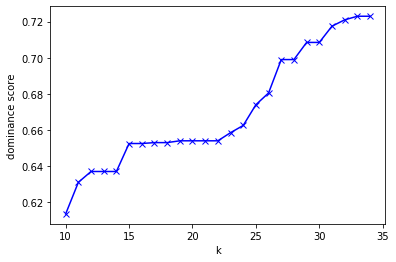

In [75]:
from sklearn.cluster import AgglomerativeClustering

model_test = AgglomerativeClustering
cluster_num_seq = range(10, 35) # minimum 10 clusters
dominance_vec = count_clustering_scores(centroid_distances, cluster_num_seq, model_test, silhouette_score, labels)
plt.plot(cluster_num_seq, dominance_vec, 'bx-')
plt.xlabel('k')
plt.ylabel('dominance score')
plt.show()

# we received a peak at k = 33 lets test it

In [76]:
model = AgglomerativeClustering(n_clusters=32, linkage = 'ward')
model.fit(centroid_distances)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=32,
                        pooling_func='deprecated')

In [77]:
np.unique(labels[model.labels_ == 9], return_counts=True)

(array([2, 3, 7, 8, 9]), array([ 2,  4, 60,  1,  3], dtype=int64))

# Checking KMeans

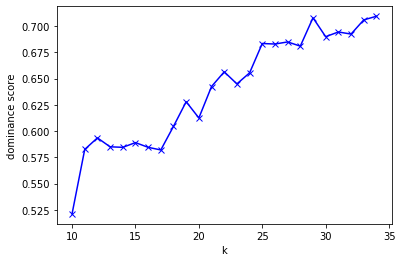

In [78]:
from sklearn.cluster import KMeans

model_test = KMeans
cluster_num_seq = range(10, 35) # minimum 10 clusters
dominance_vec = count_clustering_scores(centroid_distances, cluster_num_seq, model_test, silhouette_score, labels)
plt.plot(cluster_num_seq, dominance_vec, 'bx-')
plt.xlabel('k')
plt.ylabel('dominance score')
plt.show()

In [19]:
model = KMeans(n_clusters=31)
model.fit(centroid_distances)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=31, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [54]:
np.unique(labels[model.labels_ == 30], return_counts=True)

(array([2, 7, 8, 9]), array([26,  2,  3,  1], dtype=int64))

# Further evaluation of KMeans (Most promising until now)

### At first, we should check different KMeans algorithms

In [80]:
def count_clustering_scores(X, cluster_num, model, score_fun, labels_true):
    if isinstance(cluster_num, int):
        cluster_num_iter = [cluster_num]
    else:
        cluster_num_iter = cluster_num
        
    scores = []    
    for k in cluster_num_iter:
        model_instance = model(n_clusters=k)
        model_instance.fit(X)
        dominance = dominanceOfPredictedClusters(model_instance.labels_, labels_true)
        scores.append(dominance)
    
    if isinstance(cluster_num, int):
        return scores[0]
    else:
        return scores

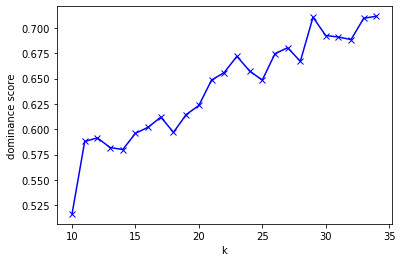

In [81]:
# AUTO
model_test = KMeans
cluster_num_seq = range(10, 35) # minimum 10 clusters
dominance_vec = count_clustering_scores(centroid_distances, cluster_num_seq, model_test, silhouette_score, labels)
plt.plot(cluster_num_seq, dominance_vec, 'bx-')
plt.xlabel('k')
plt.ylabel('dominance score')
plt.show()

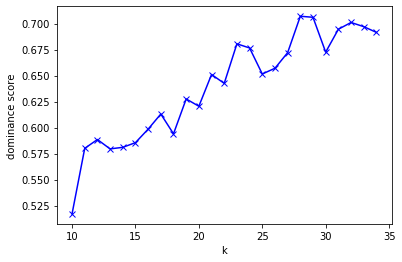

In [68]:
# FULL
model_test = KMeans
cluster_num_seq = range(10, 35) # minimum 10 clusters
dominance_vec = count_clustering_scores(centroid_distances, cluster_num_seq, model_test, silhouette_score, labels)
plt.plot(cluster_num_seq, dominance_vec, 'bx-')
plt.xlabel('k')
plt.ylabel('dominance score')
plt.show()

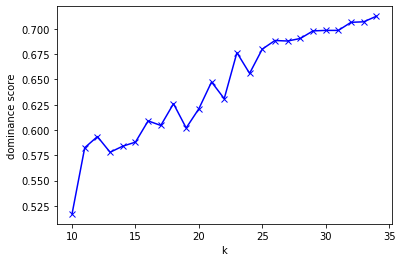

In [79]:
# ELKAN
model_test = KMeans
cluster_num_seq = range(10, 35) # minimum 10 clusters
dominance_vec = count_clustering_scores(centroid_distances, cluster_num_seq, model_test, silhouette_score, labels)
plt.plot(cluster_num_seq, dominance_vec, 'bx-')
plt.xlabel('k')
plt.ylabel('dominance score')
plt.show()

In [82]:
# AUTO - 29, FULL - 28, ELKAN - no promising spikes

## KMeans (auto) k = 29

In [83]:
model = KMeans(n_clusters=29, algorithm = 'auto')
model.fit(centroid_distances)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=29, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [115]:
np.unique(labels[model.labels_ == 29], return_counts=True)

(array([], dtype=int32), array([], dtype=int64))

## KMeans (FULL) k = 28

In [116]:
model = KMeans(n_clusters=28, algorithm = 'full')
model.fit(centroid_distances)

KMeans(algorithm='full', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=28, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [145]:
np.unique(labels[model.labels_ == 27], return_counts=True)

(array([1, 2, 3, 4, 5, 6, 8, 9]),
 array([ 2, 21, 15,  4, 34,  1, 10,  1], dtype=int64))

By checking bins of each clusters, auto algorithm seems to work a little bit better

# KMeans (auto) k = 29 - real results

In [148]:
model = KMeans(n_clusters=29, algorithm = 'auto', max_iter=1000, n_init = 20)
model.fit(centroid_distances)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1000,
       n_clusters=29, n_init=20, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [150]:
labels_true = labels
labels_pred = model.labels_

Now we need to determine, which cluster represents which digit

In [151]:
def determineClusterDigit(labels_true, labels_pred, cluster_num):
    real_labels, counts = np.unique(labels[model.labels_ == cluster_num], return_counts=True)
    return real_labels[np.argmax(counts)]

Creating mapping dictionary

In [158]:
label_mapping = dict()
n_clusters = 29
for i in range(n_clusters):
    label_mapping[i] = determineClusterDigit(labels_true, labels_pred, i)

In [166]:
labels_final_prediction = pd.Series(labels_pred)
labels_final_prediction = labels_final_prediction.map(label_mapping)

now all the labels are mapped and we can evaluate model with some metrics

## Precicion

In [173]:
from sklearn.metrics import precision_score

precision_score(y_true = labels_true, y_pred = labels_final_prediction, average='micro')

0.6845

## Recall

In [174]:
from sklearn.metrics import recall_score

recall_score(y_true = labels_true, y_pred = labels_final_prediction, average='micro')

0.6845